# Paquetes

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm



# 1. Predicting Heart Disease Using a Classification Tree (10 points)


## 1.1 Data Cleaning (2 points)


In [12]:
file_path = r"C:\Users\User\Desktop\Decision_Trees-Andr-s_Soto\Python\Input\processed.cleveland.data"
cols = [
    'age', 'sex', 'cp', 'restbp', 'chol', 'fbs',
    'restecg', 'thalach', 'exang', 'oldpeak',
    'slope', 'ca', 'thal', 'hd'
]
df = pd.read_csv(file_path, header=None, names=cols, na_values='?')
df = df.dropna()

In [13]:
categorical_vars = ['cp', 'restecg', 'slope', 'thal']
df = pd.get_dummies(df, columns=categorical_vars, drop_first=True)

df['y'] = df['hd'].apply(lambda x: 1 if x > 0 else 0)

## 1.2 Data Analysis (8 points)

### (1 point) Split the data into training and test sets, and plot a classification tree (random_state = 123).

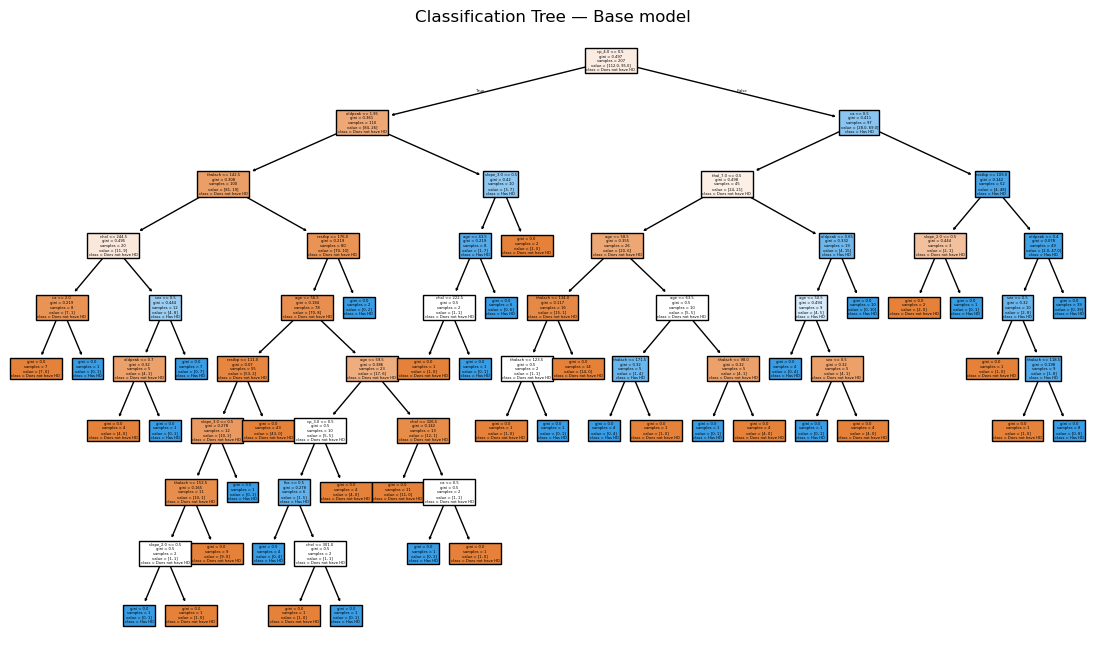

In [14]:
X = df.drop(columns=['hd', 'y'])
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=123
)

tree_base = DecisionTreeClassifier(random_state=123)
tree_base.fit(X_train, y_train)

plt.figure(figsize=(14, 8))
plot_tree(tree_base, feature_names=X.columns, class_names=["Does not have HD", "Has HD"], filled=True)
plt.title("Classification Tree — Base model")
plt.savefig(r"C:\Users\User\Desktop\Decision_Trees-Andr-s_Soto\Python\Output\classification tree 1.2 .png", dpi=300, bbox_inches='tight')
plt.show()


### (2 points) Plot the confusion matrix using the labels ["Does not have HD", "Has HD"] and interpret the results.

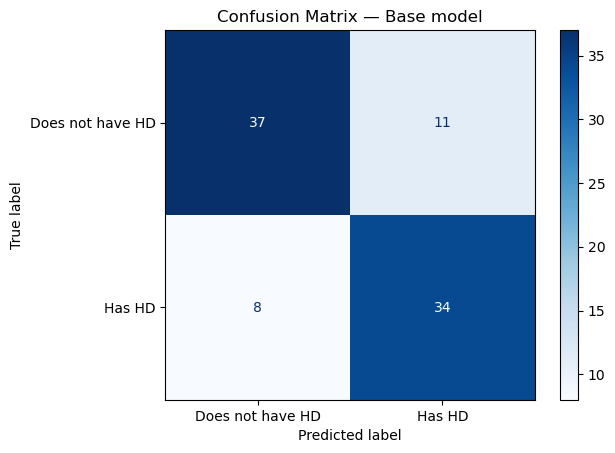

In [15]:
y_pred_base = tree_base.predict(X_test)

cm_base = confusion_matrix(y_test, y_pred_base, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm_base, display_labels=["Does not have HD", "Has HD"])
disp.plot(values_format="d", cmap="Blues")
plt.title("Confusion Matrix — Base model")
plt.savefig(r"C:\Users\User\Desktop\Decision_Trees-Andr-s_Soto\Python\Output\Confusion_Matrix.png", dpi=300, bbox_inches='tight')
plt.show()


### Confusion Matrix — Base Model

The model shows balanced performance in classifying cases with and without heart disease (HD):

- **True Negatives (37)**: Correctly predicted as *no HD*.  
- **False Positives (11)**: Incorrectly predicted as *HD* when they are not.  
- **False Negatives (8)**: Missed cases of *HD*.  
- **True Positives (34)**: Correctly identified as *HD*.

Overall, the model achieves an **accuracy of about 78%**, indicating a solid baseline performance with room for further improvement.



### (1.5 points) Fix the overfitting problem using cross-validation. Generate 50 values of α equally spaced on a logarithmic scale between e⁻¹⁰ and 0.05. Use 4-fold cross-validation to select the optimal alpha (random_state = 123).

In [16]:
alphas = np.exp(np.linspace(-10, np.log(0.05), 50))

cv = KFold(n_splits=4, shuffle=True, random_state=123)

cv_scores = []
for a in alphas:
    clf = DecisionTreeClassifier(random_state=123, ccp_alpha=a)
    scores = cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=cv)
    cv_scores.append(scores.mean())

cv_scores = np.array(cv_scores)
opt_idx = np.argmax(cv_scores)
opt_alpha = alphas[opt_idx]



### Cross-Validation to Fix Overfitting

To address the overfitting issue, a **cost-complexity pruning (ccp_alpha)** parameter was tuned using **4-fold cross-validation**.  
Fifty α values were generated on a **logarithmic scale** between `e^-10` and `0.05`.  
For each α, a decision tree was trained, and its mean cross-validation accuracy was computed.

The optimal α was selected as the one maximizing cross-validation accuracy.

- **Optimal α:** 0.037567  
- **Cross-validation mean accuracy:** 0.7294  

This value of α provides the best trade-off between model complexity and generalization, effectively mitigating overfitting.


### (1.5 points) Plot the Inaccuracy Rate (1 − Accuracy) against alpha

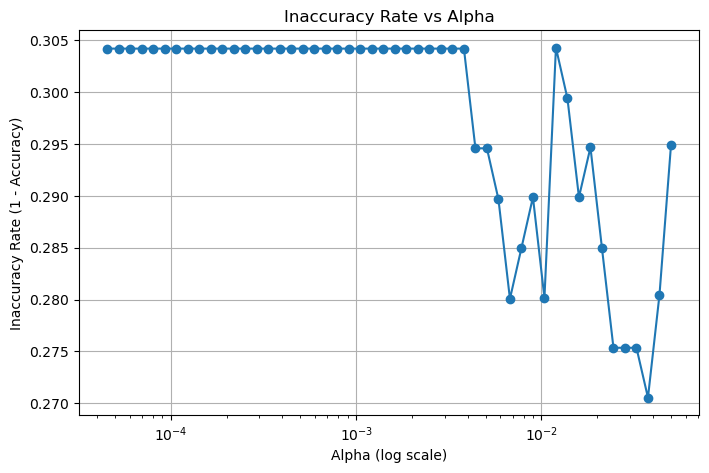

In [18]:
inaccuracy_rate = 1 - cv_scores

plt.figure(figsize=(8, 5))
plt.plot(alphas, inaccuracy_rate, marker='o')
plt.xscale('log')
plt.xlabel("Alpha (log scale)")
plt.ylabel("Inaccuracy Rate (1 - Accuracy)")
plt.title("Inaccuracy Rate vs Alpha")
plt.grid(True)
plt.savefig(r"C:\Users\User\Desktop\Decision_Trees-Andr-s_Soto\Python\Output\Inaccuracy_vs_Alpha.png", dpi=300, bbox_inches='tight')
plt.show()


### (2 points) Plot again the classification tree and the confusion matrix using the optimal α. Interpret and briefly discuss the results.

In [19]:
clf_opt = DecisionTreeClassifier(random_state=123, ccp_alpha=opt_alpha)
clf_opt.fit(X_train, y_train)


DecisionTreeClassifier(ccp_alpha=np.float64(0.037567320122730744),
                       random_state=123)

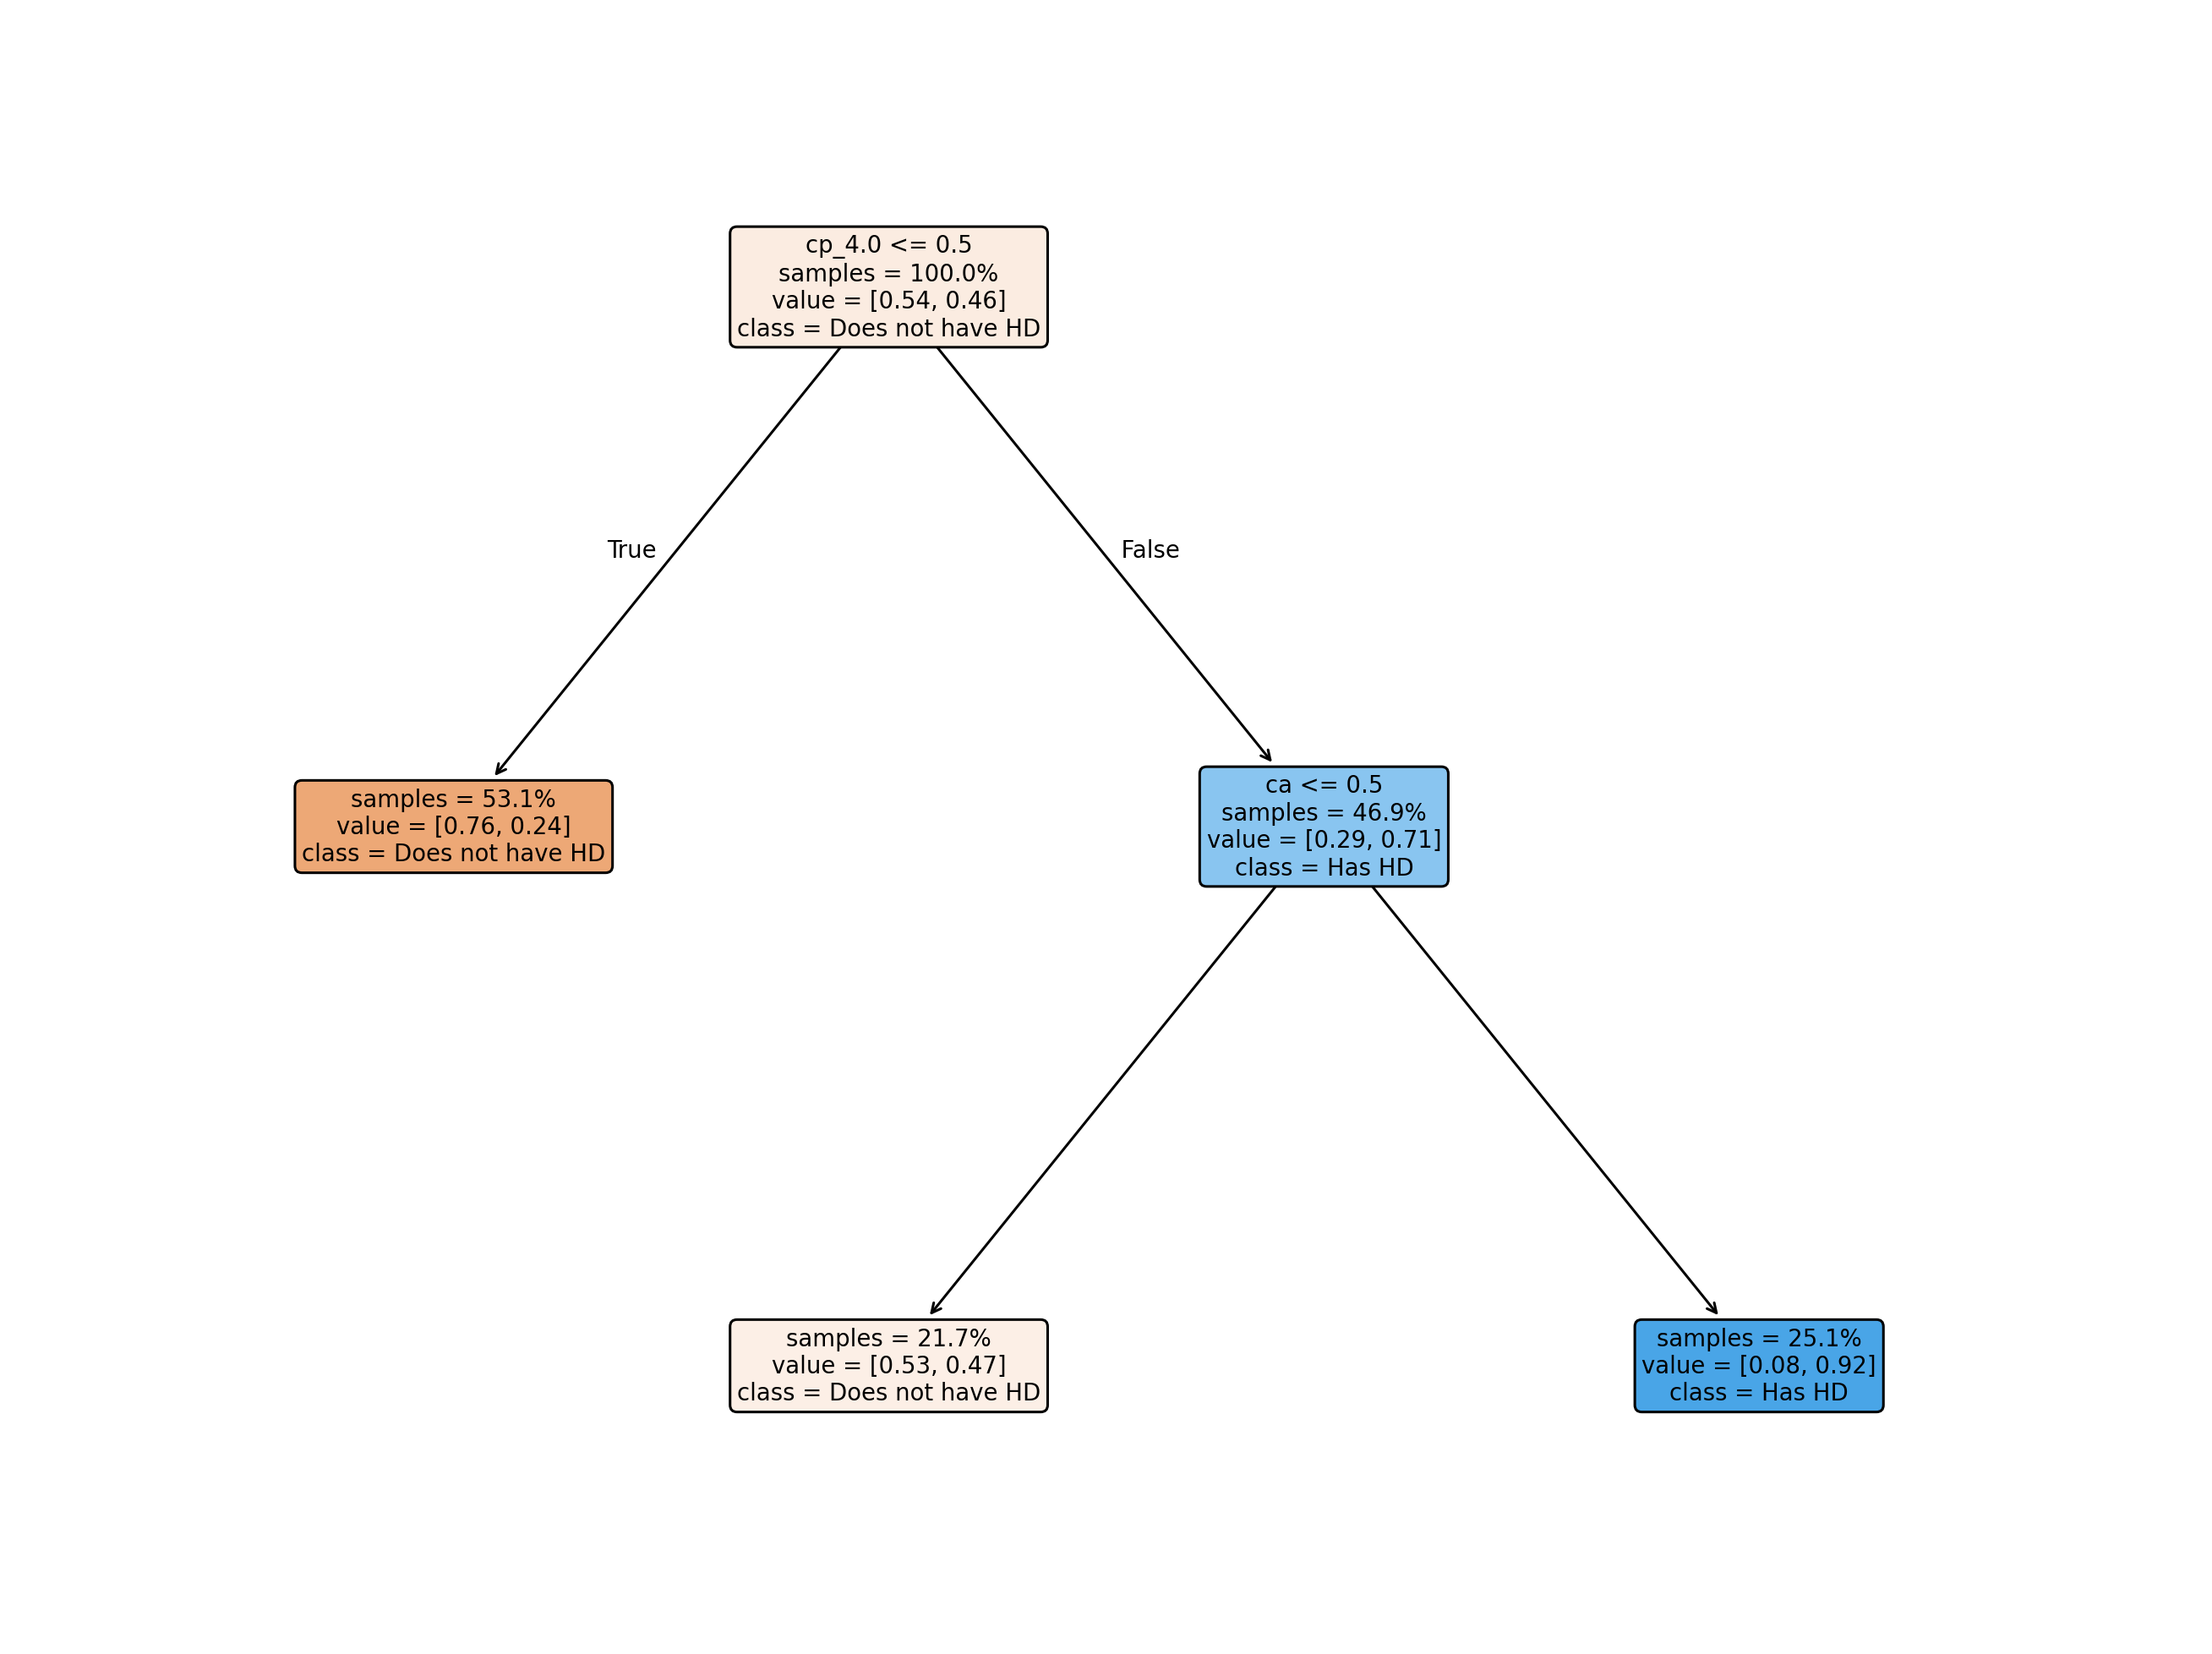

In [20]:
plt.figure(figsize=(12,9), dpi=220)
plot_tree(
    clf_opt,
    feature_names=X.columns,
    class_names=["Does not have HD", "Has HD"],
    filled=True, rounded=True,
    impurity=False, proportion=True, precision=2,
    max_depth=3,         
    fontsize=9
)
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\Decision_Trees-Andr-s_Soto\Python\Output\optimal_α_Tree_Decision.png", dpi=300, bbox_inches='tight')
plt.show()


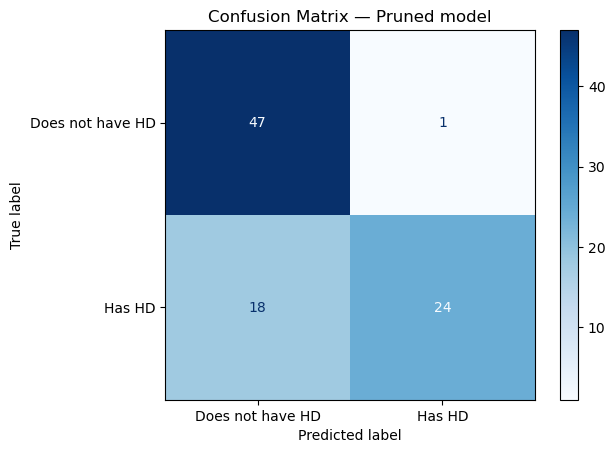

In [21]:
y_pred_opt = clf_opt.predict(X_test)
cm_opt = confusion_matrix(y_test, y_pred_opt, labels=[0, 1])
disp_opt = ConfusionMatrixDisplay(cm_opt, display_labels=["Does not have HD", "Has HD"])
disp_opt.plot(values_format="d", cmap="Blues")
plt.title("Confusion Matrix — Pruned model")
plt.savefig(r"C:\Users\User\Desktop\Decision_Trees-Andr-s_Soto\Python\Output\optimal_α_Confusion_Matrix.png", dpi=300, bbox_inches='tight')
plt.show()

### Confusion Matrix — Pruned Model

After applying cost-complexity pruning with the optimal α value, the model achieved improved generalization:

- **True Negatives (47)**: Correctly identified as *no HD*.  
- **False Positives (1)**: Few healthy cases incorrectly labeled as *HD*.  
- **False Negatives (18)**: Some *HD* cases missed by the model.  
- **True Positives (24)**: Correctly predicted as *HD*.

- **Accuracy (pruned):** 0.789  

The pruning process simplified the tree while maintaining similar accuracy, indicating **reduced overfitting** and a better bias–variance balance.  
False positives decreased substantially, while false negatives slightly increased — a trade-off worth evaluating based on clinical priorities.


# 2. Causal Forest (10 points)


In [22]:
file_path = r"C:\Users\User\Desktop\Decision_Trees-Andr-s_Soto\Python\Input\processed.cleveland.data"

cols = [
    'age', 'sex', 'cp', 'restbp', 'chol', 'fbs',
    'restecg', 'thalach', 'exang', 'oldpeak',
    'slope', 'ca', 'thal', 'hd'
]
df = pd.read_csv(file_path, header=None, names=cols, na_values='?')
df = df.dropna()

## (0.5 points) Create a binary treatment variable T that randomly takes values 0 or 1 with equal probability (simulating random assignment to the program).

In [23]:
np.random.seed(123)  
df['T'] = np.random.choice([0, 1], size=len(df), p=[0.5, 0.5])

df

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd,T
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,1
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,1
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1,0
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2,0
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3,1


## (1 point) Create an outcome variable Y that measures the improvement in cardiovascular health after the program, following the rule below:

In [24]:
np.random.seed(123)
epsilon = np.random.normal(0, 1, len(df))

df['Y'] = (1 + 0.05*df['age'] + 0.3*df['sex'] + 0.2*df['restbp']) * df['T'] + 0.5*df['oldpeak'] + epsilon

df

,age,sex,cp,restbp,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd,T,Y
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,1,33.514369
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,0,1.747345
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,0,1.582978
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,1,29.393705
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,1,29.171400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1,0,1.055832
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1,1,25.272386
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2,0,-0.223716
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3,1,31.445787


## (1 point) Calculate the treatment effect on your new outcome variable 𝑌 using OLS.



In [25]:
X1 = sm.add_constant(df[['T']])
m1 = sm.OLS(df['Y'], X1).fit(cov_type='HC1')  
print(m1.summary().tables[1])

X2 = sm.add_constant(df[['T','age','sex','restbp','oldpeak']])
m2 = sm.OLS(df['Y'], X2).fit(cov_type='HC1')
print(m2.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5377      0.102      5.281      0.000       0.338       0.737
T             30.1524      0.320     94.220      0.000      29.525      30.780
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.7137      1.623     -7.835      0.000     -15.894      -9.533
T             30.2179      0.243    124.142      0.000      29.741      30.695
age            0.0188      0.013      1.402      0.161      -0.007       0.045
sex            0.4375      0.292      1.500      0.133      -0.134       1.009
restbp         0.0861      0.012      6.989      0.000       0.062       0.110
oldpeak        0.5297      0.133      3.997      0.000       0.270       0.789


### Observation

The treatment variable **T** shows a strong and statistically significant positive effect on the outcome **Y**.  
The estimated **Average Treatment Effect (ATE)** is approximately **30.2**, both with and without controls, indicating that the inclusion of covariates does not materially change the result.  
This stability suggests that the treatment effect is robust and not driven by confounding factors.


## (2 points) Use a Random Forest model to estimate the causal effects.



In [26]:
X = df.drop(columns=['Y','T','hd'], errors='ignore')
Y = df['Y'].values
T = df['T'].astype(int).values  
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(
    X, Y, T, test_size=0.3, random_state=123, stratify=T
)



In [27]:
mu1 = RandomForestRegressor(n_estimators=500, random_state=123, n_jobs=-1)
mu0 = RandomForestRegressor(n_estimators=500, random_state=123, n_jobs=-1)

mu1.fit(X_train[T_train==1], Y_train[T_train==1])
mu0.fit(X_train[T_train==0], Y_train[T_train==0])

tau_hat = mu1.predict(X_test) - mu0.predict(X_test)
ATE = np.mean(tau_hat)

### Observation

Using the **T-learner approach with Random Forests**, the estimated **Average Treatment Effect (ATE)** is **30.52**.  
This result aligns closely with the OLS estimates, confirming that the treatment has a consistently strong positive impact on the outcome variable **Y**, even when allowing for nonlinear relationships and complex interactions.


## (2 points) Plot a representative tree that captures the most important heterogeneous treatment effects with a maximum depth of 2 (max_depth=2) and interpret it.

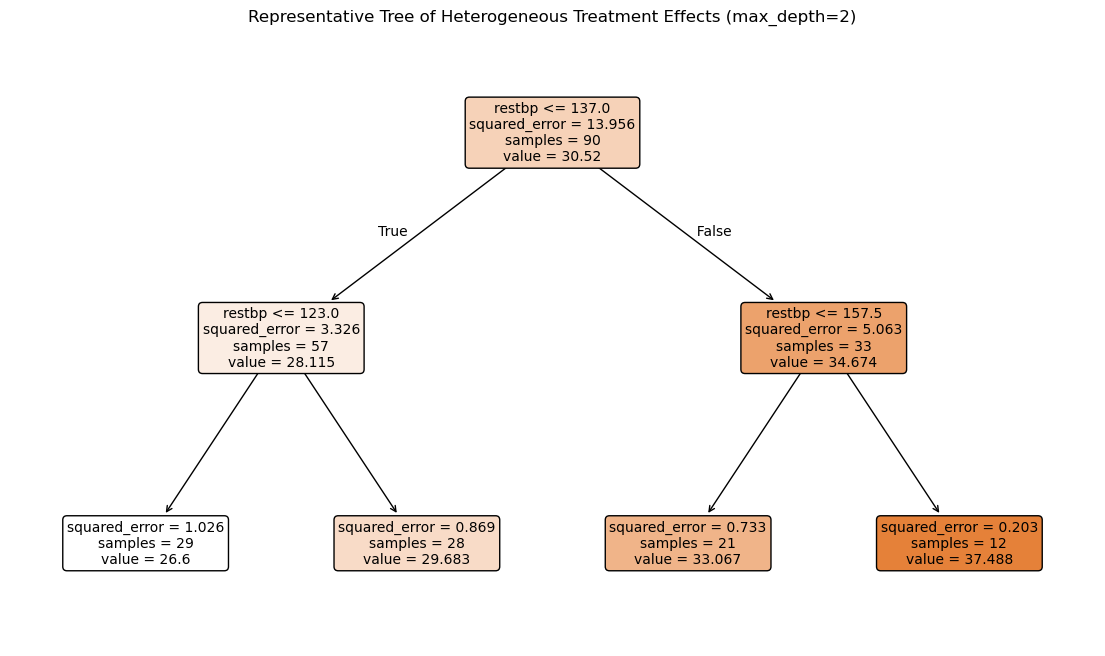

In [28]:
tree = DecisionTreeRegressor(max_depth=2, random_state=123)
tree.fit(X_test, tau_hat)

plt.figure(figsize=(14, 8))
plot_tree(
    tree,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Representative Tree of Heterogeneous Treatment Effects (max_depth=2)")
plt.savefig(r"C:\Users\User\Desktop\Decision_Trees-Andr-s_Soto\Python\Output\Tree_Causal_Forest_2.png", dpi=300, bbox_inches='tight')
plt.show()



## (1.5 points) Compute the feature importances and visualize them in a bar chart.



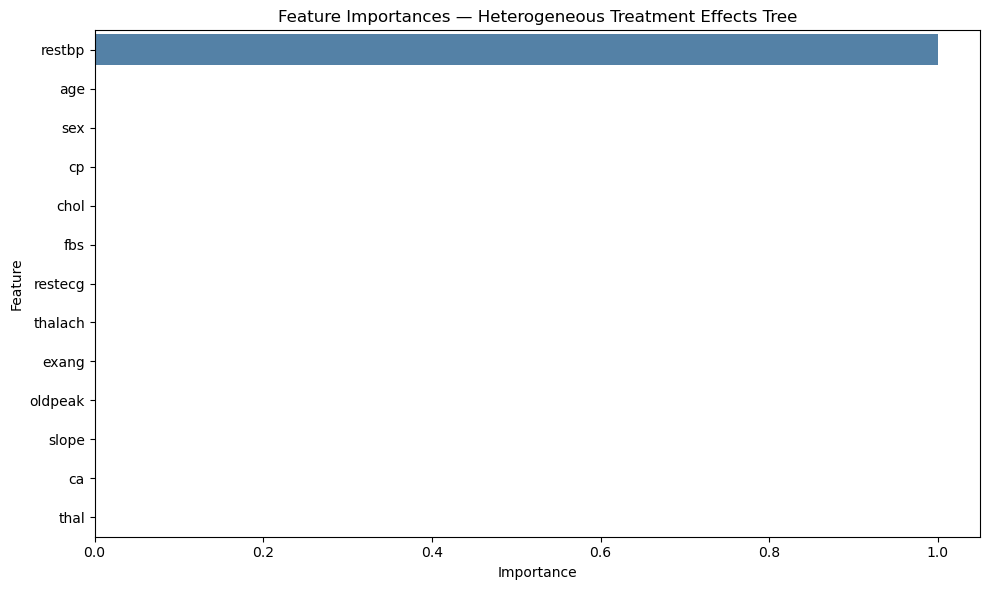

restbp     1.0
age        0.0
sex        0.0
cp         0.0
chol       0.0
fbs        0.0
restecg    0.0
thalach    0.0
exang      0.0
oldpeak    0.0
slope      0.0
ca         0.0
thal       0.0
dtype: float64


In [29]:
importances = tree.feature_importances_
feat_imp = pd.Series(importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, color='steelblue')
plt.title("Feature Importances — Heterogeneous Treatment Effects Tree")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\Decision_Trees-Andr-s_Soto\Python\Output\Feature_Importances_Causal_Forest_2.png", dpi=300, bbox_inches='tight')
plt.show()

print(feat_imp.round(4))


### Interpretation

Resting blood pressure (**restbp**) is identified as the **main factor driving variation in the treatment effect**.  
Individuals with different baseline blood pressure levels experience **significantly distinct treatment effects**, suggesting strong heterogeneity along this dimension.  
Other features do not exhibit relevant heterogeneity at this tree depth, indicating that **restbp** is the dominant moderator in the model’s interpretation.


## (2 points) Plot the distribution of standardized covariates by predicted treatment effect terciles



C:\Users\User\AppData\Local\Temp\ipykernel_25668\1898865659.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = Xz.groupby(terciles).mean().loc[["Low","Mid","High"]]


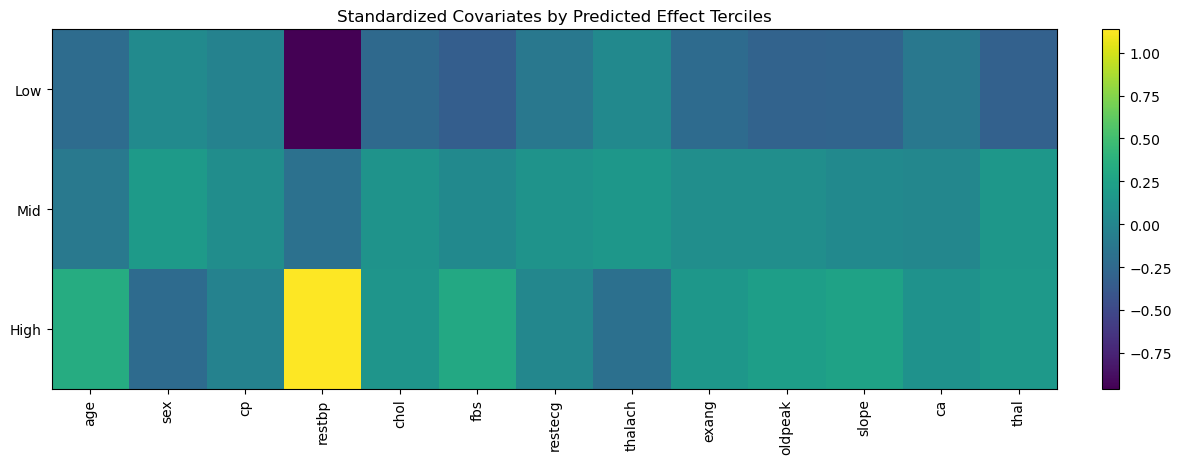

In [31]:
Xnum = X_test.select_dtypes(include=[np.number]).copy()
scaler = StandardScaler().fit(Xnum)
Xz = pd.DataFrame(scaler.transform(Xnum), columns=Xnum.columns, index=Xnum.index)
terciles = pd.qcut(pd.Series(tau_hat, index=Xz.index), q=3, labels=["Low", "Mid", "High"])
means = Xz.groupby(terciles).mean().loc[["Low","Mid","High"]]
plt.figure(figsize=(12, 4 + 0.25*len(means)))
im = plt.imshow(means.values, aspect='auto', interpolation='nearest')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.yticks(range(len(means.index)), means.index)
plt.xticks(range(len(means.columns)), means.columns, rotation=90)
plt.title("Standardized Covariates by Predicted Effect Terciles")
plt.tight_layout()
plt.savefig(r"C:\Users\User\Desktop\Decision_Trees-Andr-s_Soto\Python\Output\terciles_heatmap.png", dpi=300)
plt.show()

In [32]:
print(means.round(3).to_markdown())


|      |    age |    sex |     cp |   restbp |   chol |    fbs |   restecg |   thalach |   exang |   oldpeak |   slope |     ca |   thal |
|:-----|-------:|-------:|-------:|---------:|-------:|-------:|----------:|----------:|--------:|----------:|--------:|-------:|-------:|
| Low  | -0.22  |  0.045 | -0.034 |   -0.961 | -0.243 | -0.337 |    -0.125 |     0.038 |  -0.226 |    -0.295 |  -0.287 | -0.123 | -0.313 |
| Mid  | -0.114 |  0.18  |  0.068 |   -0.176 |  0.114 |  0.031 |     0.114 |     0.15  |   0.075 |     0.076 |   0.036 |  0.011 |  0.148 |
| High |  0.334 | -0.225 | -0.034 |    1.137 |  0.129 |  0.307 |     0.011 |    -0.188 |   0.151 |     0.219 |   0.251 |  0.112 |  0.165 |


### Summary

People with higher resting blood pressure (**restbp**) and slightly higher cholesterol and blood sugar (**fbs**) show a stronger treatment effect.  
Those with lower values for these indicators tend to respond less.  
Overall, the effect of the treatment seems more noticeable in individuals with higher cardiovascular risk factors.

